# Project 4 - West Nile Virus Prediction

## Problem Statement
The intent of this project is to analyze weather data and GIS data and predicting the presence of the West Nile virus, for a given time, location, and species. 

##  General Approach
- [Data cleaning and imputation](#Data-Cleaning)
- [Data visualization](#Data-Visualization)
- [Feature selection](#Featuion-Selection)
- [Cross validation](#Cross-Validation)
- [Model fitting](#Model-Fitting)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from haversine import haversine

In [2]:
# Load dataset 
train = pd.read_csv('assets/train_cleaned.csv')
test = pd.read_csv('assets/test_cleaned.csv')
weather = pd.read_csv('assets/weather_cleaned.csv')
spray = pd.read_csv('assets/spray.csv')

### Data Cleaning and Imputation

#### Weather data

In [3]:
# verifying the dataframe
weather.head()

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Rain
0,1,2007-05-01,83,50,66.5,51,56,0.0,29.10,29.82,1.7,27,9.2,0
1,2,2007-05-01,84,52,68.0,51,57,0.0,29.18,29.82,2.7,25,9.6,0
2,1,2007-05-02,59,42,50.5,42,47,0.0,29.38,30.09,13.0,4,13.4,0
3,2,2007-05-02,60,43,51.5,42,47,0.0,29.44,30.08,13.3,2,13.4,0
4,1,2007-05-03,66,46,56.0,40,48,0.0,29.39,30.12,11.7,7,11.9,0


In [4]:
# checking the datatypes
weather.dtypes

Station          int64
Date            object
Tmax             int64
Tmin             int64
Tavg           float64
DewPoint         int64
WetBulb          int64
PrecipTotal    float64
StnPressure    float64
SeaLevel       float64
ResultSpeed    float64
ResultDir        int64
AvgSpeed       float64
Rain             int64
dtype: object

In [5]:
# changing Date to DateTime 
weather['Date'] = pd.to_datetime(weather['Date'])

In [6]:
# verifying the change
weather.dtypes

Station                 int64
Date           datetime64[ns]
Tmax                    int64
Tmin                    int64
Tavg                  float64
DewPoint                int64
WetBulb                 int64
PrecipTotal           float64
StnPressure           float64
SeaLevel              float64
ResultSpeed           float64
ResultDir               int64
AvgSpeed              float64
Rain                    int64
dtype: object

#### Train data

In [7]:
train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Month,Year,Weekday,Tot_Mos_Species
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",PIPIENS/RESTUANS,41,N OAK PARK AVE,2,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,5,2007,Tuesday,1
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",RESTUANS,41,N OAK PARK AVE,2,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,5,2007,Tuesday,1
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",RESTUANS,62,N MANDELL AVE,7,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,5,2007,Tuesday,1
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",PIPIENS/RESTUANS,79,W FOSTER AVE,15,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,5,2007,Tuesday,1
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",RESTUANS,79,W FOSTER AVE,15,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,5,2007,Tuesday,4


In [8]:
# function takes in coordinates from train data and output station number closest to it
def closest_point(point):
    station1, station2 = [41.995, -87.933], [41.786, -87.752]  # Fixed coordinates for two stations
    points = [station1, station2] 
    if cdist([point], points).argmin() == 0: return 1 # return index of closest point
    return 2

In [9]:
# Assign Station to train data based on station coordinates
train['Station'] = [closest_point(x) for x in train[['Latitude','Longitude']].values]

In [10]:
# Convert test and train data to datetime format
train['Date'] = pd.to_datetime(train['Date'])

In [11]:
# verifying the changes
train.dtypes

Date                      datetime64[ns]
Address                           object
Species                           object
Block                              int64
Street                            object
Trap                               int64
AddressNumberAndStreet            object
Latitude                         float64
Longitude                        float64
AddressAccuracy                    int64
NumMosquitos                       int64
WnvPresent                         int64
Month                              int64
Year                               int64
Weekday                           object
Tot_Mos_Species                    int64
Station                            int64
dtype: object

### Feature Engineering

In [12]:
weather = weather.set_index('Date')

In [13]:
for c in ['PrecipTotal','Tavg','Tmin','Tmax','DewPoint']:
    for p in [14,28,60]:
        if c == 'PrecipTotal':
            weather[f'{c}_{str(p)}'] = weather[c].rolling(p, min_periods=1).sum()
        elif c == 'Tmin':
            weather[f'{c}_{str(p)}'] = weather[c].rolling(p, min_periods=1).min()
        elif c == 'Tmax':
            weather[f'{c}_{str(p)}'] = weather[c].rolling(p, min_periods=1).max()
        else:
            weather[f'{c}_{str(p)}'] = weather[c].rolling(p, min_periods=1).mean()

In [14]:
weather.head(20)

,Station,Tmax,Tmin,Tavg,DewPoint,WetBulb,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,...,Tavg_60,Tmin_14,Tmin_28,Tmin_60,Tmax_14,Tmax_28,Tmax_60,DewPoint_14,DewPoint_28,DewPoint_60
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-01,1,83,50,66.5,51,56,0.00,29.10,29.82,1.7,...,66.500000,50.0,50.0,50.0,83.0,83.0,83.0,51.000000,51.000000,51.000000
2007-05-01,2,84,52,68.0,51,57,0.00,29.18,29.82,2.7,...,67.250000,50.0,50.0,50.0,84.0,84.0,84.0,51.000000,51.000000,51.000000
2007-05-02,1,59,42,50.5,42,47,0.00,29.38,30.09,13.0,...,61.666667,42.0,42.0,42.0,84.0,84.0,84.0,48.000000,48.000000,48.000000
2007-05-02,2,60,43,51.5,42,47,0.00,29.44,30.08,13.3,...,59.125000,42.0,42.0,42.0,84.0,84.0,84.0,46.500000,46.500000,46.500000
2007-05-03,1,66,46,56.0,40,48,0.00,29.39,30.12,11.7,...,58.500000,42.0,42.0,42.0,84.0,84.0,84.0,45.200000,45.200000,45.200000
2007-05-03,2,67,48,57.5,40,50,0.00,29.46,30.12,12.9,...,58.333333,42.0,42.0,42.0,84.0,84.0,84.0,44.333333,44.333333,44.333333
2007-05-04,1,66,49,57.5,41,50,0.00,29.31,30.05,10.4,...,58.214286,42.0,42.0,42.0,84.0,84.0,84.0,43.857143,43.857143,43.857143
2007-05-04,2,78,51,64.5,42,50,0.00,29.36,30.04,10.1,...,59.000000,42.0,42.0,42.0,84.0,84.0,84.0,43.625000,43.625000,43.625000
2007-05-05,1,66,53,59.5,38,49,0.00,29.40,30.10,11.7,...,59.055556,42.0,42.0,42.0,84.0,84.0,84.0,43.000000,43.000000,43.000000


### Merge weather and train data

In [15]:
# Merge train data with weather based on date and station number
train = train.merge(weather, on=['Date','Station'])

In [16]:
# Create dummies for species columns
df = pd.get_dummies(train, columns=['Species'])

In [17]:
# Create month and day columns
df['Month'] = df['Date'].dt.month
df["Day"] = df['Date'].dt.dayofyear

### Data Visualization and Removing Collinear Features

In [18]:
df.dtypes.keys()

Index(['Date', 'Address', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet',
       'Latitude', 'Longitude', 'AddressAccuracy', 'NumMosquitos',
       'WnvPresent', 'Month', 'Year', 'Weekday', 'Tot_Mos_Species', 'Station',
       'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'PrecipTotal',
       'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed',
       'Rain', 'PrecipTotal_14', 'PrecipTotal_28', 'PrecipTotal_60', 'Tavg_14',
       'Tavg_28', 'Tavg_60', 'Tmin_14', 'Tmin_28', 'Tmin_60', 'Tmax_14',
       'Tmax_28', 'Tmax_60', 'DewPoint_14', 'DewPoint_28', 'DewPoint_60',
       'Species_Others', 'Species_PIPIENS', 'Species_PIPIENS/RESTUANS',
       'Species_RESTUANS', 'Day'],
      dtype='object')

In [19]:
# separating the numerical data types from the object data types
df_num = df.drop(columns=df.dtypes[df.dtypes == 'object'].keys())

In [20]:
# verifying the change
df_num.columns

Index(['Date', 'Block', 'Trap', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent', 'Month', 'Year', 'Tot_Mos_Species',
       'Station', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'PrecipTotal',
       'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed',
       'Rain', 'PrecipTotal_14', 'PrecipTotal_28', 'PrecipTotal_60', 'Tavg_14',
       'Tavg_28', 'Tavg_60', 'Tmin_14', 'Tmin_28', 'Tmin_60', 'Tmax_14',
       'Tmax_28', 'Tmax_60', 'DewPoint_14', 'DewPoint_28', 'DewPoint_60',
       'Species_Others', 'Species_PIPIENS', 'Species_PIPIENS/RESTUANS',
       'Species_RESTUANS', 'Day'],
      dtype='object')

In [21]:
# dropping the remaining 'categorical' features (Date, Block, Trap, Latitude, Longitude, AddressAccuracy, Month, Year,
# Rain, Species_Others, 'Species_PIPIENS', 'Species_PIPIENS/RESTUANS', 'Species_RESTUANS', 'Day', 'Station' )
df_cont = df_num[['NumMosquitos', 'Tot_Mos_Species', 'Tmax', 'Tmin', 'Tavg',
                  'DewPoint', 'WetBulb', 'PrecipTotal',
                  'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed', 'PrecipTotal_14', 'PrecipTotal_28', 'PrecipTotal_60', 'Tavg_14',
                  'Tavg_28', 'Tavg_60', 'Tmin_14', 'Tmin_28', 'Tmin_60', 'Tmax_14',
                  'Tmax_28', 'Tmax_60', 'DewPoint_14', 'DewPoint_28', 'DewPoint_60', 'WnvPresent']]

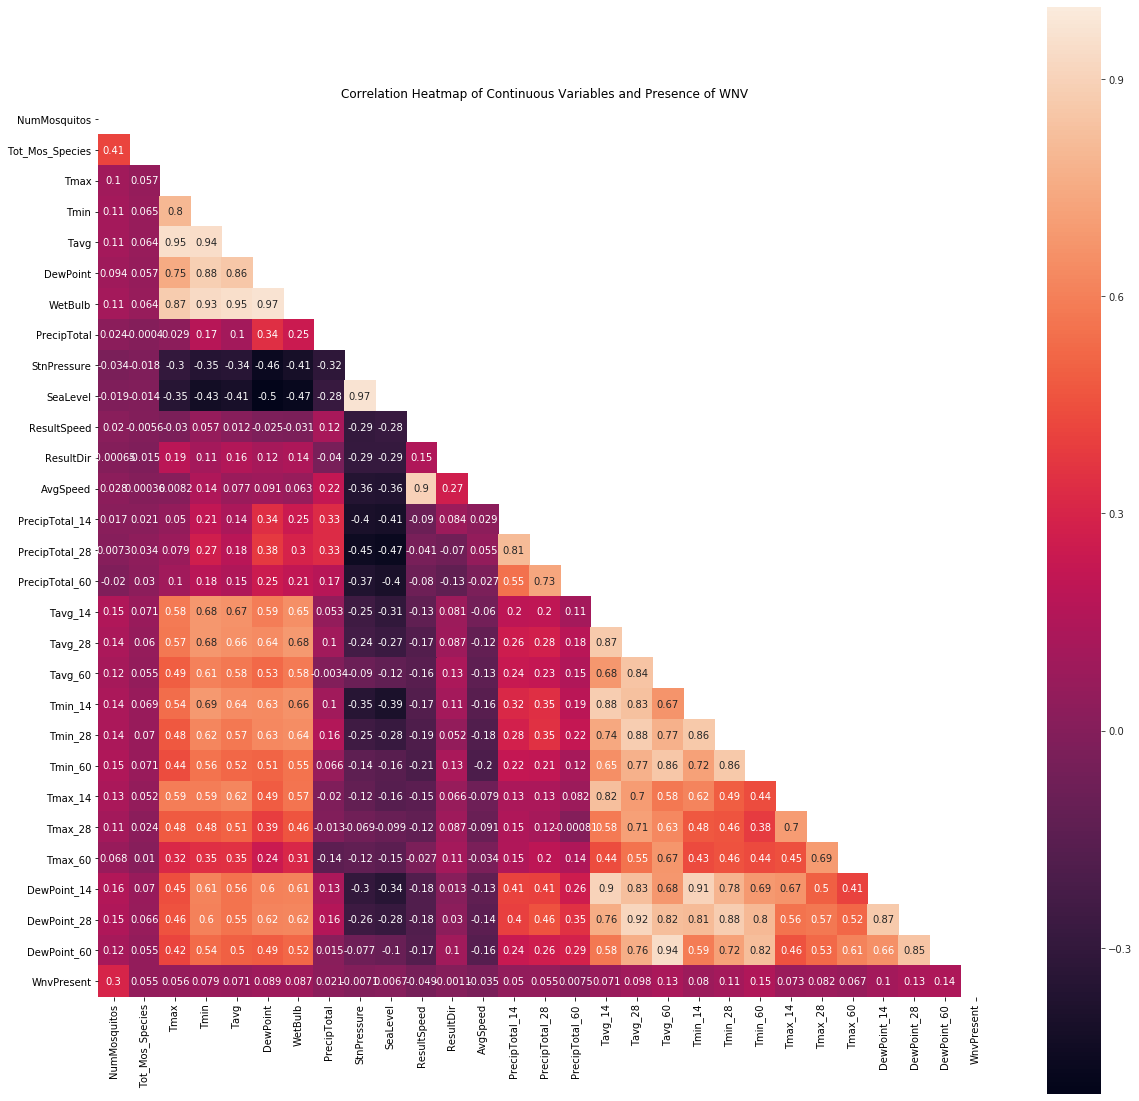

In [22]:
#establish figure size
plt.figure(figsize=(20,20))

#setting title
ax = plt.axes()
ax.set_title('Correlation Heatmap of Continuous Variables and Presence of WNV')

#set up mask to be "True" in the upper triangle
mask = np.zeros_like(df_cont.corr())
mask[np.triu_indices_from(mask)] = True

#plotting heatmap while masking upper triangle with white
with sns.axes_style("white"):
    sns.heatmap(df_cont.corr(), mask=mask, square = True, annot=True)

From the heatmap, we can see that there are a few collinear features (including their rolls):
- AvgSpeed & ResultSpeed
- SeaLevel & StnPressure
- WetBulb & Tmax, Tmin, Tavg, DewPoint 

In [23]:
# checking collinear terms against WnvPresent
np.abs(df[['AvgSpeed', 'ResultSpeed', 'WnvPresent']].corr().loc['WnvPresent'])

AvgSpeed       0.034605
ResultSpeed    0.048893
WnvPresent     1.000000
Name: WnvPresent, dtype: float64

In [24]:
# checking collinear terms against WnvPresent
np.abs(df[['SeaLevel', 'StnPressure', 'WnvPresent']].corr().loc['WnvPresent'])

SeaLevel       0.006738
StnPressure    0.007149
WnvPresent     1.000000
Name: WnvPresent, dtype: float64

In [25]:
# checking collinear terms against WnvPresent
np.abs(df[['WetBulb', 'Tmax', 'Tmax_14', 'Tmax_28', 'Tmax_60', 'Tmin', 'Tmin_14', 'Tmin_28', 'Tmin_60',
           'Tavg', 'Tavg_14', 'Tavg_28', 'Tavg_60','DewPoint','DewPoint_14', 'DewPoint_28', 'DewPoint_60',
           'WnvPresent']].corr().loc['WnvPresent'])

WetBulb        0.087295
Tmax           0.056156
Tmax_14        0.073485
Tmax_28        0.082459
Tmax_60        0.067110
Tmin           0.078749
Tmin_14        0.080009
Tmin_28        0.110154
Tmin_60        0.154747
Tavg           0.070603
Tavg_14        0.070628
Tavg_28        0.097595
Tavg_60        0.130006
DewPoint       0.088737
DewPoint_14    0.103341
DewPoint_28    0.132170
DewPoint_60    0.142533
WnvPresent     1.000000
Name: WnvPresent, dtype: float64

We will then pick the features with higher (absolute) correlation vs presence of WNV to keep from the pairs:
- ResultSpeed (0.048893)
- StnPressure (0.007149)
- DewPoint (0.087295) (including DewPoint's rolls)

In [26]:
# dropping collinear terms with less correlation with target variable
df = df.drop(columns=['AvgSpeed', 'SeaLevel', 'WetBulb', 'Tmax', 'Tmax_14', 'Tmax_28', 'Tmax_60',
                      'Tmin', 'Tmin_14', 'Tmin_28', 'Tmin_60',
                      'Tavg', 'Tavg_14', 'Tavg_28', 'Tavg_60'])

In [27]:
# verifying the changes
df.columns

Index(['Date', 'Address', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet',
       'Latitude', 'Longitude', 'AddressAccuracy', 'NumMosquitos',
       'WnvPresent', 'Month', 'Year', 'Weekday', 'Tot_Mos_Species', 'Station',
       'DewPoint', 'PrecipTotal', 'StnPressure', 'ResultSpeed', 'ResultDir',
       'Rain', 'PrecipTotal_14', 'PrecipTotal_28', 'PrecipTotal_60',
       'DewPoint_14', 'DewPoint_28', 'DewPoint_60', 'Species_Others',
       'Species_PIPIENS', 'Species_PIPIENS/RESTUANS', 'Species_RESTUANS',
       'Day'],
      dtype='object')

### Finding location with high WnvPresent

In [28]:
# Find out coordinates with the highest WnvPresent
train[train['WnvPresent'] == 1].groupby('Latitude')['Longitude'].value_counts().sort_values(ascending=False)

Latitude   Longitude 
41.974689  -87.890615    29
41.673408  -87.599862    15
41.954690  -87.800991    15
41.964242  -87.757639    14
41.743402  -87.731435    11
                         ..
41.800737  -87.711880     1
41.778748  -87.586427     1
41.772846  -87.740029     1
41.768388  -87.678649     1
41.644612  -87.604498     1
Name: Longitude, Length: 99, dtype: int64

In [29]:
# top 2 coordinates with high presence of WNV
wnvpresent_lat_lon  = [(41.974689, -87.890615), (41.673408, -87.599862)]

In [30]:
# Calculate the haversine distance from train data to coordiates with wnv persent area
for i,area in enumerate(wnvpresent_lat_lon):
    df['Dist_' + str(i)] = [haversine(row, (area),unit='mi') for row in zip(train['Latitude'],train['Longitude'])]
    

In [31]:
# Display numeric data
df._get_numeric_data().columns

Index(['Block', 'Trap', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent', 'Month', 'Year', 'Tot_Mos_Species',
       'Station', 'DewPoint', 'PrecipTotal', 'StnPressure', 'ResultSpeed',
       'ResultDir', 'Rain', 'PrecipTotal_14', 'PrecipTotal_28',
       'PrecipTotal_60', 'DewPoint_14', 'DewPoint_28', 'DewPoint_60',
       'Species_Others', 'Species_PIPIENS', 'Species_PIPIENS/RESTUANS',
       'Species_RESTUANS', 'Day', 'Dist_0', 'Dist_1'],
      dtype='object')

In [32]:
# features to include in model
features = ['DewPoint', 'PrecipTotal', 'StnPressure', 'ResultSpeed', 'ResultDir', 'Rain',
            'PrecipTotal_14', 'PrecipTotal_28', 'PrecipTotal_60', 'DewPoint_14', 'DewPoint_28','DewPoint_60',
            'Species_Others', 'Species_PIPIENS', 'Species_PIPIENS/RESTUANS', 'Species_RESTUANS',
            'Month', 'Day', 'Dist_0', 'Dist_1']

In [33]:
X = df[features]
y = df['WnvPresent']

### Using SMOTE to handle the unbalanced data

In [34]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X, y = smote.fit_resample(X, y) 

### Modeling

#### Random Forest Classifier

In [35]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [36]:
# initiating and fitting 
rfc = RandomForestClassifier(class_weight='balanced', max_features='sqrt',
                             min_samples_leaf=5, n_estimators=1000, n_jobs=-1, random_state=8)
rfc.fit(X, y)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)

In [37]:
# looking at the important features
feature_import = rfc.feature_importances_
pd.DataFrame(columns=['feature', 'importance'], 
             data=list(zip(features, feature_import))).sort_values('importance',ascending=False).head(19)


,feature,importance
11,DewPoint_60,0.120441
17,Day,0.103546
15,Species_RESTUANS,0.097625
18,Dist_0,0.091602
19,Dist_1,0.080730
10,DewPoint_28,0.064095
14,Species_PIPIENS/RESTUANS,0.054754
16,Month,0.047996
9,DewPoint_14,0.046940
13,Species_PIPIENS,0.044584


#### SVM

In [38]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [39]:
# initiating standard scalar
ss = StandardScaler()

In [40]:
# fit and transform
X = ss.fit_transform(X)

In [41]:
# iniating
svm = SVC(probability=True, random_state=8)

In [42]:
# fitting
svm.fit(X,y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=8, shrinking=True, tol=0.001,
    verbose=False)

## Handling the Test Data 


In [43]:
# Assigning nearest station to each row, changing date object type and merging with the weather data 
# to align with df
test['Station'] = [closest_point(x) for x in test[['Latitude','Longitude']].values]
test['Date'] = pd.to_datetime(test['Date'])
test = test.merge(weather, on=['Date','Station'])
test = pd.get_dummies(test, columns=['Species'])
test['Month'] = test['Date'].dt.month
test["Day"] = test['Date'].dt.dayofyear

In [44]:
# Repeat for test data
for i,area in enumerate(wnvpresent_lat_lon):
    test['Dist_' + str(i)] = [haversine(row, (area),unit='mi') for row in zip(test['Latitude'],test['Longitude'])]

In [45]:
# Make match above
X_test = test[features]

## Predictions

In [46]:
def preds(model, X_test):
    if model == 'rfc':
        pred = rfc.predict_proba(X_test)
        submission = pd.DataFrame(columns=['Id', 'WnvPresent'], data=list(zip(test['Id'], pred)))
        submission.WnvPresent = submission['WnvPresent'].map(lambda x: x[1])
        submission.to_csv('submission_rfc_new.csv',index=False)        
        
    elif model == 'svm':
        pred = svm.predict_proba(ss.transform(X_test))
        submission = pd.DataFrame(columns=['Id', 'WnvPresent'], data=list(zip(test['Id'], pred)))
        submission.WnvPresent = submission['WnvPresent'].map(lambda x: x[1])
        submission.to_csv('submission_svm_new.csv',index=False)        
    return pred

In [47]:
# Whatever model you decided on:
predictions = svm.predict(ss.transform(X_test))

In [48]:
predictions_rfc = preds('rfc', X_test)
predictions_svm = preds('svm', X_test)

## Kaggle Score

We managed to obtain a better Kaggle score using RandomForectClassifer (0.75095) vs SupportVectorMachine (0.70675).